In [9]:
import nltk
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import *
from pylab import *

import seaborn as sns # poista?
from scipy import stats as sts # zipf, linreg, powerlaw
from scipy.stats import t
import scipy.optimize as opt
from scipy.stats import invgamma

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Resources:
1. https://www.nltk.org/book/
2. Draw Zipf plot: https://finnaarupnielsen.wordpress.com/2013/10/22/zipf-plot-for-word-counts-in-brown-corpus/
3. Zipf plot Python 3: https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
4. Estimate alpha: http://www-personal.umich.edu/~mejn/courses/2006/cmplxsys899/powerlaws.pdf (also, https://arxiv.org/pdf/0706.1062.pdf pages 6, 36,)
5. Powerlaw package: https://arxiv.org/pdf/1305.0215.pdf

Read data, tokenize and calculate frequencies and ranks.

*TO-DO: tokenization paremmin*

In [4]:
files = ["flatland.txt", "panama-canal.txt", "ulysses.txt"]
books = []

# Read data and save books to dict
for f in files:
    file = open(f, "r", encoding='utf-8')
    book = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(book)
    file.close()

books = {files[0]: books[0], files[1]: books[1], files[2]: books[2]}

# Tokenize and count frequencies
tokens = {}
counts = {}
ranks = {}
freqs = {}

for b in books:
    tokens_w_count = Counter(map(str.lower, books[b]))
    tokens[b] = sorted([k for k in tokens_w_count.keys()])
    counts[b] = np.array([tokens_w_count[k] for k in tokens[b]])
    ranks[b] = np.arange(1, len(counts[b]) + 1)
    indices = np.argsort(-counts[b])
    freqs[b] = counts[b][indices]


In [10]:
# Eetun koodi

def tokenizer(words):
    # https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
    tokens_with_count = Counter(map(str.lower, book_words))
    return tokens_with_count

def token_counter(tokens_with_count):
    tokens = sorted([k for k in tokens_with_count.keys()])
    counts = np.array([tokens_with_count[k] for k in tokens])
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]
    return ranks, indices, frequencies

def sw_filter(book_words):
    stop_words = stopwords.words('english')
    stop_words.append('The')
    filtered_words = [w.lower() for w in book_words if not w.lower() in stop_words]
    ftokens_with_count = Counter(map(str.lower, filtered_words))
    topwords = [t[0] for t in ftokens_with_count.most_common(20)]
    doclen = len(ftokens_with_count)
    return filtered_words, ftokens_with_count, topwords, doclen

In [11]:
files = ["flatland.txt", "panama-canal.txt", "ulysses.txt"]
books = []

for f in files:
    file = open(f, "r", encoding='utf-8')
    b = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(b)
    file.close()

tcounts = []
tokens = []
counts = []
for b in books:
    words, tcs, _, _ = sw_filter(b)
    tokens.append(list(tcs.keys()))
    counts.append(tcs.values())
    tcounts.append(tcs)

ranks = []
freqs = []
for tc in tcounts:
    r, _, f = token_counter(tc)
    ranks.append(r)
    freqs.append(f)
    
for i in range(len(books)):
    books[i] = " ".join(books[i]).lower()

In [12]:
books = pd.DataFrame({'book_name': ["flatland", "panama-canal", "ulysses"], 
                      'book_text': books, 'ranks': ranks, 'freqs': freqs, 
                      'tokens': tokens, 'counts': counts})
books = books.set_index("book_name")

In [13]:
books.head()

,book_text,ranks,freqs,tokens,counts
book_name,,,,,
flatland,the nature flatland call our world flatland no...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[151, 107, 94, 90, 82, 81, 80, 75, 73, 71, 70,...","[nature, flatland, call, world, make, clearer,...","(40, 75, 38, 19, 34, 1, 6, 15, 4, 3, 54, 5, 6,..."
panama-canal,the project gutenberg the panama canal saxon m...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[609, 404, 299, 279, 213, 171, 162, 140, 138, ...","[project, gutenberg, panama, canal, saxon, mil...","(106, 89, 404, 609, 8, 3, 38, 5, 7, 33, 47, 3,..."
ulysses,produced david widger complete grant man propo...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1524, 1278, 1213, 1110, 1047, 871, 840, 836, ...","[produced, david, widger, complete, grant, man...","(11, 3, 1, 47, 53, 182, 2, 5, 1, 90, 28, 38, 7..."


### Task 1.

Use appropriate NLTK coding (you can inspire from coding examples of the online NLTK book) in order to **plot the histogram of the twenty most frequent words** in each of the three ebooks. **Comment on the nature of these words** in terms of their relevance to the content of the ebook. Suggest your own approach to evaluate such relevancy.  

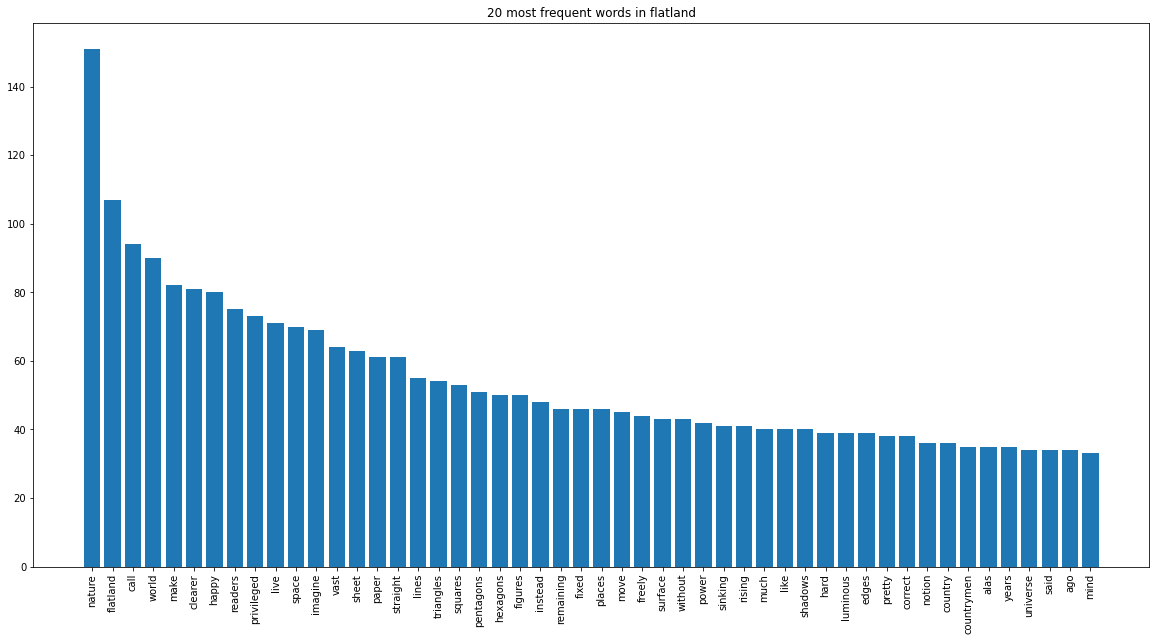

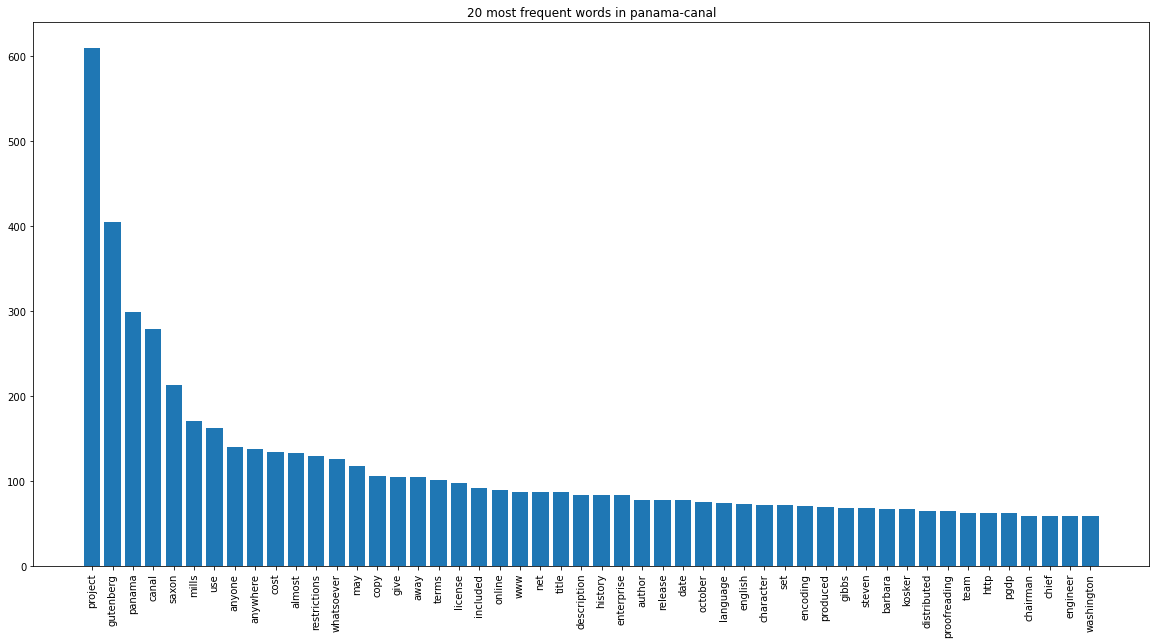

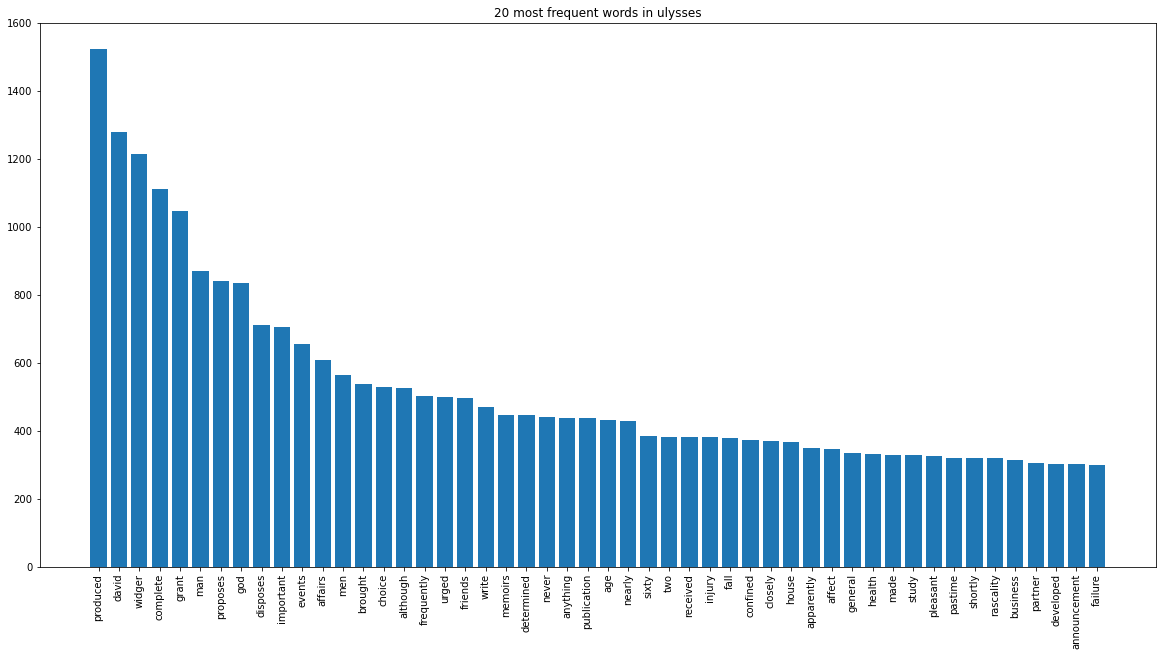

In [14]:
for b in books.index:
    df = pd.DataFrame({'word': books.tokens[b], 'count': books.freqs[b]}).sort_values(by=['count'], ascending=False).head(50)
    #df = df.sort_values(by=['count']) # ascending for plot

    x = list(df.loc[:, 'word'])
    y = list(df.loc[:, 'count'])
    
    plt.figure(figsize=(20,10))
    title("20 most frequent words in " + b)
    plt.bar(x, y)
    plt.xticks(rotation='vertical')
    plt.show() 

**Comment on the nature of these words in terms of their relevance to the content of the ebook:**
- Kussakin kirjassa enimmäkseen stopwordeja/epärelevantteja semantiikan näkökulmasta
- Sisältö/konteksti tulee varmaan parhaiten selville panaman kanaalista kertovan kirjan kohdalla, flatlandin sisällöstä ei näiden perusteella saa paljoa selville


**Suggest your own approach to evaluate such relevancy:**
- Alkajaisiksi stopwordit pois ja sitten vastaava listaus frekvenssijärjestyksessä
- muita ideoita?

### Task 2 & 3.
2. Use the frequency of the words to fit the Zipf distribution for each ebook. Draw the zipf fitting cure for each ebook and comment on the goodness of fit.


3. We would like to **quantify the goodness of fit of the Zipf law** using the statistical confidence bound at 90% confidence. Ideally, we should obtain an upper curve and a lower curve around the Zipf law cure. If the fitting is statistically valid at 90% confidence, then all points should be located within this upper and lower curve. Test different values of the confidence value, e.g., 80%, 85%, 90% and 95% and report the number of points that fall outside the upper and lower bounds for each case.


#### Draw Zipf plots (log-log)

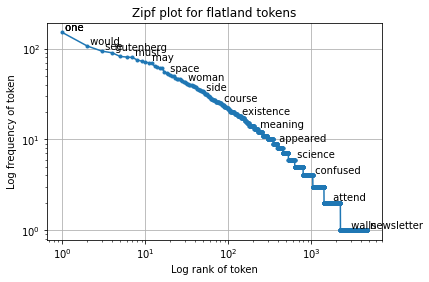

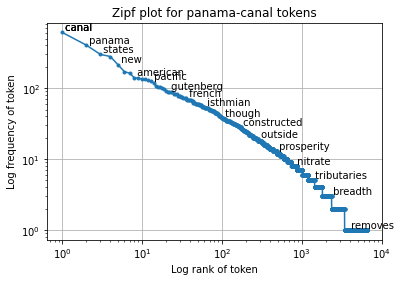

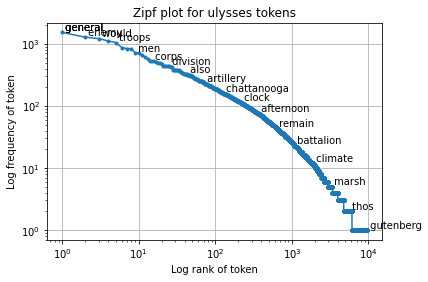

In [15]:
for b in books.index:
    indices = np.argsort(-np.fromiter(books.counts[b], dtype=float))
    
    loglog(books.ranks[b], books.freqs[b], marker=".")
    title("Zipf plot for " + b + " tokens")
    xlabel("Log rank of token")
    ylabel("Log frequency of token")
    grid(True)
    for n in list(logspace(-0.5, log10(len(books.counts[b])), 20).astype(int)):
        # Not all words fit on x-axis; using try-except to break out of loop
        try:
            dummy = text(books.ranks[b][n], books.freqs[b][n], " " + books.tokens[b][indices[n]], 
                         verticalalignment = "bottom", horizontalalignment = "left")
        except IndexError:
            break
    show()

#### Fit Zipf curve

Zipf distribution: $f(r) \sim r^{-\alpha}$, $\alpha \approx 1$ 

(Kurssikirja: $\alpha = 1$)

*Although there is no exact closed-form expression for $\hat{\alpha}$ in the discrete case, an approximate expression can be derived. --* (Source: https://wiki.santafe.edu/images/6/66/CSN_07_PowerlawDistributionsInEmpiricalData_arxiv.pdf , pg. 5)

Approximate ML estimator for shape parameter $\alpha$ in discrete data:

> $ \hat{\alpha} = 1 + n\left( \sum_{i=1}^n ln \frac{x_i}{x_{min} - \frac{1}{2}} \right)^{-1} $

In [16]:
def ahat(n, rank):
    return 1 + ( n / sum(log(rank / min(rank) - 0.5) ))

In [14]:
def zipfcurve():
    for b in books.index:
        # Estimate alpha
        alpha = ahat(len(books.ranks[b]), books.ranks[b])
        
        # Zipf pmf
        p = sts.zipf.pmf(books.ranks[b], alpha)
    
        # Fit curve
        plt.figure(figsize=(8,4))
        total = sum(books.freqs[b])
        plt.title("With stopwords:" + str(b))
        plt.scatter(books.ranks[b], books.freqs[b])
        plt.plot(books.ranks[b], (1 / books.ranks[b]) * total, lw=1, color='green')
        plt.plot(books.ranks[b], p * total, lw=1, color='red')
        plt.ylabel("Frequency")
        plt.xlabel("Rank")
        plt.xlim(0, 100) # limit y and x-axis to better see the fit
        plt.ylim(0, max(p * total + 0.005 * total)) 
        plt.tight_layout()
        red_patch = matplotlib.patches.Patch(color='red', label='alpha = ' + str(alpha))
        green_patch = matplotlib.patches.Patch(color='green', label='alpha = 1')
        plt.legend(handles=[red_patch, green_patch])
        plt.show()

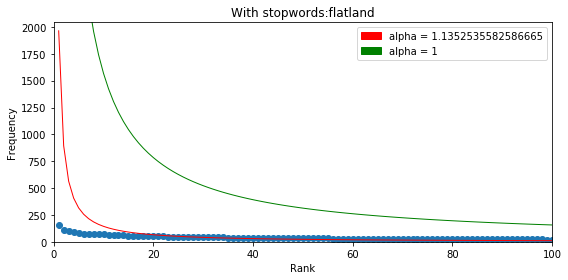

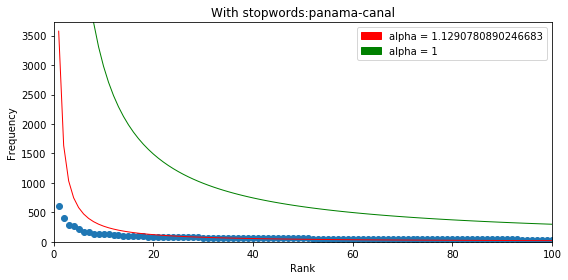

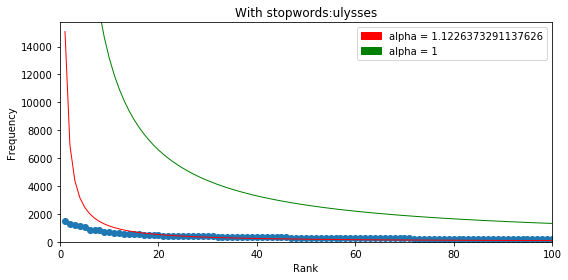

In [15]:
zipfcurve()

#### Fit linear regression

Sovitin kirjojen dataan lineaarisen regressiomallin ja laskin ja piirsin sovitteiden luottamusvälit ja ennustevälit.
Luottamusvälit erottuu kuvista sovitteen ympäriltä kun kuvaan zoomaa käyrän kohdalta.

- Luottamusvälit näyttäisi ainakin näin laskettuna jäävän melko kapeiksi, niin että sinne ei osu juuri yhtään pisteitä. (Tyyliin 100-200 per 4000-9000).
- Kuitenkin tuon 3-kohdan tehtävänannon perusteella tuntuisi että halutulle luottamusvälille osuisi suurehko osa pisteistä.
- Ennustevälit olisi leveämpiä, mutta niitä ei kai varsinaisesti kysytty. 
- Toinen vaihtoehto olisi sovittaa jokin muu malli, mutta tuo tehtävänannon vihje spacy.stats.linregress -paketista viittaisi mun mielestä nimenomaan lineaariseen malliin. 

Olisko teillä jotain muuta tulkintaa tuosta tehtävänannosta?

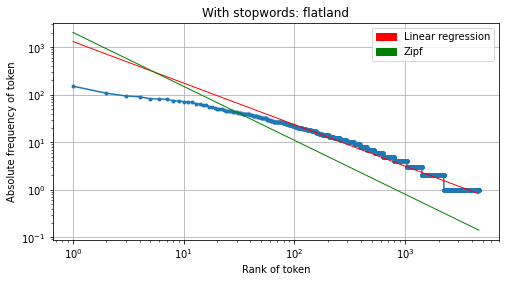

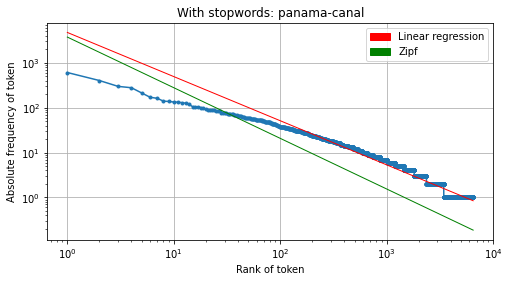

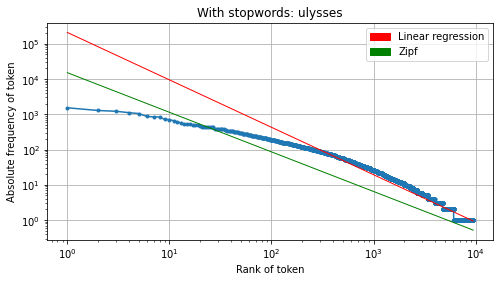

In [17]:
for b in books.index:
    # Fit Linear regression
    slope, intercept, _, _, std_err = sts.linregress(log(books.ranks[b]), log(books.freqs[b]))
    y = intercept + slope * log(books.ranks[b])
    
    # Fit Zipf
    alpha = ahat(len(books.ranks[b]), books.ranks[b])
    p = sts.zipf.pmf(books.ranks[b], alpha)
    total = sum(books.freqs[b])

    # Plot observations
    plt.figure(figsize=(8,4))
    title("With stopwords: " + b)
    plt.loglog(books.ranks[b], books.freqs[b], marker=".")
    
    # Plot linear regression
    plt.plot(books.ranks[b], exp(y), lw=1, color="red")
    
    # Plot Zipf
    plt.plot(books.ranks[b], p * total, lw=1, color="green")
    
    plt.ylabel("Absolute frequency of token")
    plt.xlabel("Rank of token")
    red_patch = matplotlib.patches.Patch(color='red', label='Linear regression')
    green_patch = matplotlib.patches.Patch(color='green', label='Zipf')
    plt.legend(handles=[red_patch, green_patch])
    plt.grid(axis="both")
    plt.show()

## Task 6.

We would like to fit the power-law with exponential cutoff instead of standard zipf distribution. Repeat 2) and 3) and compare the fitting of the Zipf law to that of power-law with exponential cutoff for each of the two ebooks.

#### Power law with exponential cutoff (aka Truncated power law)

Wikipedia:
> $f(x) \propto x^{\alpha}e^{\beta x} $ 

Lectures:

> $p(x) \sim x^{-\alpha}e^{-x/\kappa} \Rightarrow log(p(x)) = -\alpha log(x) + \frac{1}{\kappa}x$

Some paper:
> $p(x) \sim x^{-\alpha}e^{-\lambda x} \Rightarrow log(p(x)) = -\alpha log(x) + \lambda x$, where $\lambda = \frac{1}{\kappa}$

Inverse gamma:
> $f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{-\alpha+1}e^{-\beta / x}$

### A) Estimointi scipyn optimizerilla

Expcutoff with a shift curve_fitilla: https://www.iditect.com/how-to/52455210.html

In [18]:
# Exponential cutoff with a shift --> parempi sovitus optimizerilla
def expcutoff_shift(x, alpha, beta, x0):
    #return x**(alpha) * exp(-beta * x)
    return (x + x0)**(-alpha) * np.exp(-beta * x)

<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in power
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: invalid value encountered in power
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in exp
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in multiply
  return (x + x0)**(-alpha) * np.exp(-beta * x)


-0.35071533317078524 0.006748847120194135


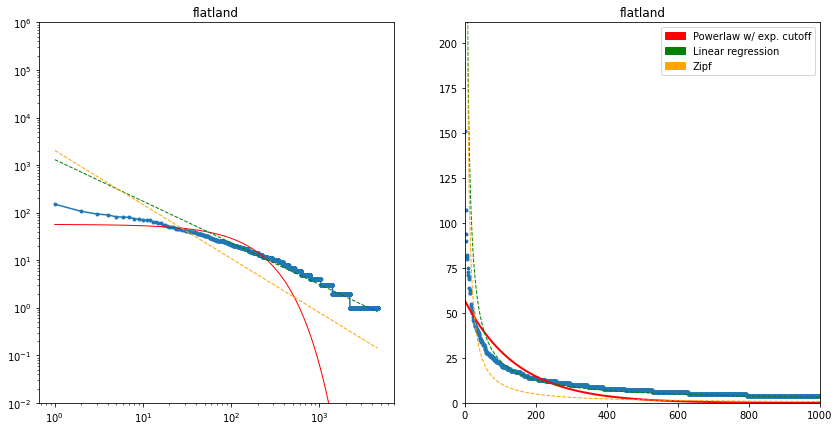

<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in power
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: invalid value encountered in power
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in exp
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in multiply
  return (x + x0)**(-alpha) * np.exp(-beta * x)


-0.5336883832804739 0.024529950970341902


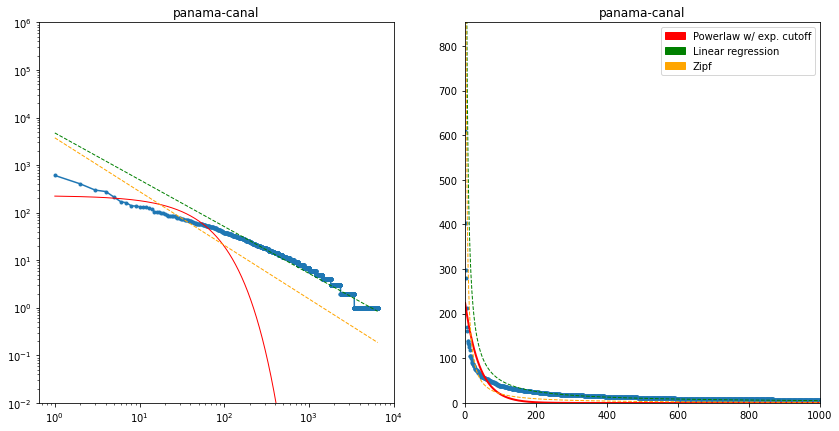

<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in power
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: invalid value encountered in power
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in exp
  return (x + x0)**(-alpha) * np.exp(-beta * x)
<ipython-input-18-9f69e5153818>:4: RuntimeWarning: overflow encountered in multiply
  return (x + x0)**(-alpha) * np.exp(-beta * x)


-0.5870268766375815 0.011069943218754876


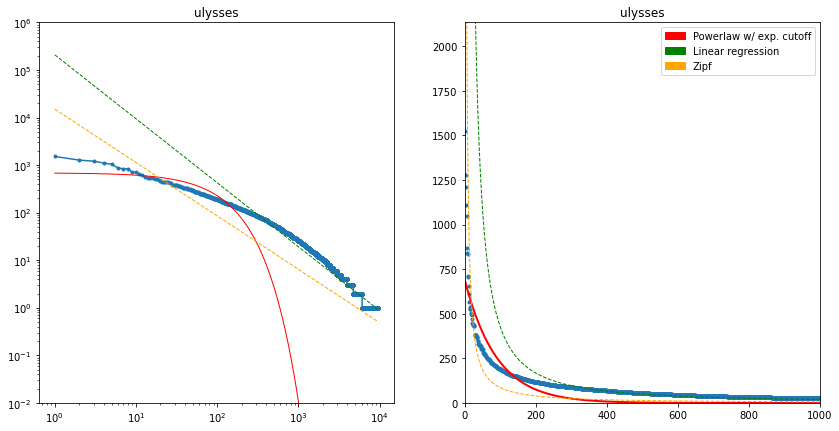

In [23]:
for b in books.index:
    fig, axs = plt.subplots(1, 2, figsize=(14,7))
    
    # Fit linreg
    slope, intercept, _, _, _ = sts.linregress(log(books.ranks[b]), log(books.freqs[b]))
    y = intercept + log(books.ranks[b]) * slope
    
    # Fit Zipf
    alpha_zipf = ahat(len(books.ranks[b]), books.ranks[b])
    p_zipf = sts.zipf.pmf(books.ranks[b], alpha_zipf)
    total = sum(books.freqs[b])
    
    # Fit powerlaw expcutoff
    fit = opt.curve_fit(expcutoff_shift, books.ranks[b], books.freqs[b])
    alpha, beta, x0 = fit[0]
    fitted_val = expcutoff_shift(books.ranks[b], alpha, beta, x0)
    
    print(alpha, beta)

    # Plot loglog
    axs[0].set_title(b)
    axs[0].loglog(books.ranks[b], books.freqs[b], marker=".") # observations
    axs[0].plot(books.ranks[b], fitted_val, lw=1, color='red') # expcutoff
    axs[0].plot(books.ranks[b], exp(y), lw=1, linestyle="--", color='green') # linreg
    axs[0].plot(books.ranks[b], p_zipf * total, lw=1, linestyle="--", color="orange") # zipf
    axs[0].set_ylim(10e-3, 10e5)
    red_patch = matplotlib.patches.Patch(color='red', label='Powerlaw w/ exp. cutoff')
    green_patch = matplotlib.patches.Patch(color='green', label='Linear regression')
    orange_patch = matplotlib.patches.Patch(color='orange', label='Zipf')
    plt.legend(handles=[red_patch, green_patch, orange_patch])
    
    # Plot linear
    axs[1].set_title(b)
    axs[1].scatter(books.ranks[b], books.freqs[b], marker=".") # observations
    axs[1].plot(books.ranks[b], fitted_val, lw=2, color='red') # expcutoff
    axs[1].plot(books.ranks[b], exp(y), lw=1, linestyle="--", color='green') # linreg
    axs[1].plot(books.ranks[b], p_zipf * total, lw=1, linestyle="--", color="orange") # zipf
    axs[1].set_xlim(0, 1000)
    axs[1].set_ylim(0, max(books.freqs[b]) + 0.4 * max(books.freqs[b]))
    #plt.grid(axis="both")
    plt.show()

### ???

Esimerkeissä optimointi näyttää toimivan parhaiten kun y_data on skaalattu välille [0,1]. Kokeillaan skaalata arvot jakamalla frekvenssien summalla.

<ipython-input-38-9f69e5153818>:4: RuntimeWarning: overflow encountered in exp
  return (x + x0)**(-alpha) * np.exp(-beta * x)


1.3113995796145688 -0.0003838131607684342


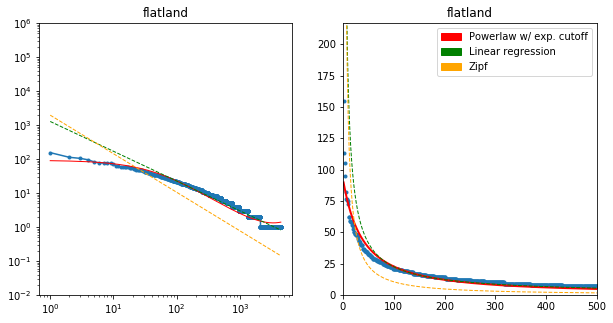

<ipython-input-38-9f69e5153818>:4: RuntimeWarning: overflow encountered in exp
  return (x + x0)**(-alpha) * np.exp(-beta * x)


1.474458707765052 -0.0005612249322644377


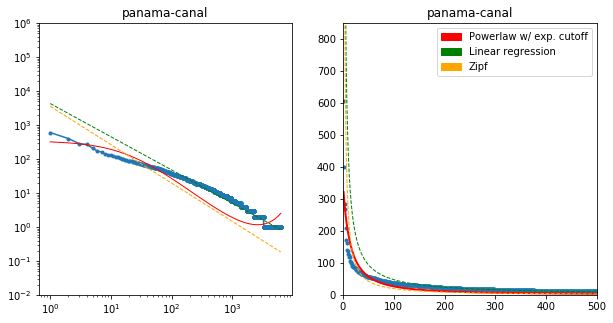

<ipython-input-38-9f69e5153818>:4: RuntimeWarning: overflow encountered in exp
  return (x + x0)**(-alpha) * np.exp(-beta * x)


1.3314566635741303 -0.00018465624521314623


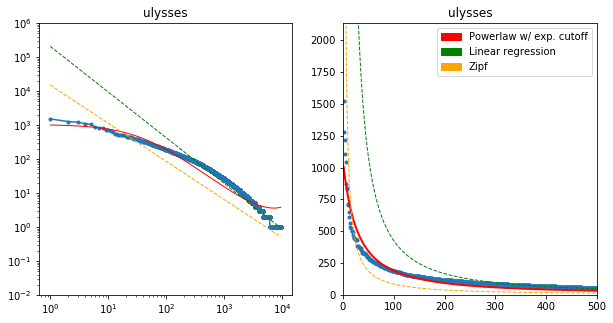

In [145]:
for b in books.index:
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    # Fit linreg
    slope, intercept, _, _, _ = sts.linregress(log(books.ranks[b]), log(books.freqs[b]))
    y = intercept + log(books.ranks[b]) * slope
    
    # Fit Zipf
    alpha_zipf = ahat(len(books.ranks[b]), books.ranks[b])
    p_zipf = sts.zipf.pmf(books.ranks[b], alpha_zipf)
    total = sum(books.freqs[b])
    
    # Fit powerlaw expcutoff
    fit = opt.curve_fit(expcutoff_shift, books.ranks[b], (books.freqs[b]/total))
    alpha, beta, x0 = fit[0]
    p = expcutoff_shift(books.ranks[b], alpha, beta, x0)
    
    print(alpha, beta)

    # Plot loglog
    axs[0].set_title(b)
    axs[0].loglog(books.ranks[b], books.freqs[b], marker=".") # observations
    axs[0].plot(books.ranks[b], p * total, lw=1, color='red') # expcutoff
    axs[0].plot(books.ranks[b], exp(y), lw=1, linestyle="--", color='green') # linreg
    axs[0].plot(books.ranks[b], p_zipf * total, lw=1, linestyle="--", color="orange") # zipf
    axs[0].set_ylim(10e-3, 10e5)
    red_patch = matplotlib.patches.Patch(color='red', label='Powerlaw w/ exp. cutoff')
    green_patch = matplotlib.patches.Patch(color='green', label='Linear regression')
    orange_patch = matplotlib.patches.Patch(color='orange', label='Zipf')
    plt.legend(handles=[red_patch, green_patch, orange_patch])
    
    # Plot linear
    axs[1].set_title(b)
    axs[1].scatter(books.ranks[b], books.freqs[b], marker=".") # observations
    axs[1].plot(books.ranks[b], p * total, lw=2, color='red') # expcutoff
    axs[1].plot(books.ranks[b], exp(y), lw=1, linestyle="--", color='green') # linreg
    axs[1].plot(books.ranks[b], p_zipf * total, lw=1, linestyle="--", color="orange") # zipf
    axs[1].set_xlim(0, 500)
    axs[1].set_ylim(0, max(books.freqs[b]) + 0.4 * max(books.freqs[b]))
    #plt.grid(axis="both")
    
    plt.show()

## Task 7.

We would like to test the **Zipf’s law on word categories** instead of the whole set of words. For this purpose, using the topic of the ebook content, suggest appropriate identification of LIWC category (ies); for instance, horror like ebook would entail Psychological process like categories. 

You should notice that LIWC full list of wording is not freely available, so you may use alternatives provided in the lecture handout or suggest your own alternative.

Once appropriate category is found, you should only construct the frequency graph with respect to words of that category, and then try to fit the Zipf’s curve distribution. 

If more than one category is found to match the ebook content, select the category that contains the higher number of words. Devise appropriate high level description of your implementation -how this has been achieved.

### LIWC (Linquistin Inquiry and Word Count)

- Alternative categories: http://www.wjh.harvard.edu/~inquirer/homecat.htm
